In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
df =  pd.read_csv('housings.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [11]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [12]:
df['median_house_value'].describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

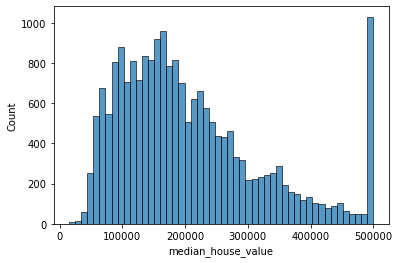

In [13]:
# to check if median_house_value is longtailed

sns.histplot(df.median_house_value, bins=50)

In [14]:
# to remove the unnessary column

df1 = df.drop(['ocean_proximity'], axis='columns')

In [15]:
# to find the nan values

df1.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [16]:
# median of population

df1['population'].median()

1166.0

In [17]:
# spliting the initial dataset in train(60),val(20) and test(20)
n = len(df1)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]

In [18]:
df_test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
9221,-120.26,37.13,33.0,1239.0,250.0,648.0,227.0,2.0278,58800.0,INLAND
10234,-117.91,33.86,26.0,2296.0,570.0,1415.0,527.0,2.4732,165800.0,<1H OCEAN
4763,-118.36,34.04,48.0,1769.0,429.0,993.0,405.0,2.3214,139400.0,<1H OCEAN
9062,-118.15,34.69,32.0,1300.0,234.0,712.0,249.0,3.2500,107500.0,INLAND
1874,-119.97,38.93,24.0,856.0,185.0,388.0,108.0,3.1806,107200.0,INLAND


In [19]:
# to reset the index 

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [20]:
# to apply the log transformation to the median_house_value 

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

In [21]:
# removing median_house_value which is the target value from the dataframe

del df_train['median_house_value']
del df_val['median_house_value']    
del df_test['median_house_value']

In [37]:
# training a linear regression model without regularization

def train_linear_regression(x, y):
    ones = np.ones(x.shape[0])
    x = np.column_stack([ones, x])

    XTX = x.T.dot(x)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(x.T).dot(y)
    
    return w[0], w[1:]


In [28]:
check = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

def prepare_X(df, fillna_value):
    df_num = df[check]
    df_num = df_num.fillna(fillna_value)
    x = df_num.values
    return x

In [29]:
# rmse

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error **2).mean()
    return np.sqrt(mse)

In [30]:
# evaluation of the model using validation dataset and the nan values with the mean 

mean = df_train.population.mean()

x_mean_train = prepare_X(df_train, fillna_value=mean)
w_0_mean, w_mean = train_linear_regression(x_mean_train, y_train)

In [31]:
X_mean_val = prepare_X(df_val, fillna_value=mean)
y_mean_pred_val = w_0_mean + X_mean_val.dot(w_mean)

In [32]:
# rounding up of the value to 2 places

np.round(rmse(y_val, y_mean_pred_val),2)

0.33

In [33]:
# filling the nan values with 0

X_null_train = prepare_X(df_train, fillna_value=0)
w_0_null, w_null = train_linear_regression(X_null_train, y_train)

In [34]:
X_null_val = prepare_X(df_val, fillna_value=0)
y_null_pred_val = w_0_null + X_null_val.dot(w_null)

In [35]:
np.round(rmse(y_val, y_null_pred_val),2)

0.33

In [38]:
# function to train a regularized linear regression

def train_linear_regression_reg(x, y, r=0.0):
    ones = np.ones(x.shape[0])
    x = np.column_stack([ones, x])

    XTX = x.T.dot(x)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(x.T).dot(y)
    
    return w[0], w[1:]

In [39]:
# trying different values of r 

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_null_train, y_train, r=r)
    y_null_reg_val = w_0 + X_null_val.dot(w)
    
#     using rmse to evaluate the model on the validation dataset
    rmse_val = np.round(rmse(y_val, y_null_reg_val),2)
    print(r, w_0, rmse_val)

0 -11.686975241970226 0.33
1e-06 -11.686959175950335 0.33
0.0001 -11.68536886556655 0.33
0.001 -11.670931318286257 0.33
0.01 -11.528493586076086 0.33
0.1 -10.274500282121712 0.33
1 -4.920480897796898 0.33
5 -1.482095745685135 0.34
10 -0.7899311832050503 0.34


In [44]:
# trying different seed values

rmse_list = []

for r in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:

    idx = np.arange(n)
    np.random.seed(r)
    np.random.shuffle(idx)

    df_shuffled = df1.iloc[idx]
    
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train + n_val:].copy()

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train_orig = df_train.median_house_value.values
    y_val_orig = df_val.median_house_value.values
    y_test_orig = df_test.median_house_value.values

    y_train = np.log1p(y_train_orig)
    y_val = np.log1p(y_val_orig)
    y_test = np.log1p(y_test_orig)
    
    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
    X_null_train = prepare_X(df_train, fillna_value=0)
    w_0, w = train_linear_regression(X_null_train, y_train)
    
    X_null_val = prepare_X(df_val, fillna_value=0)
    y_null_reg_val = w_0 + X_null_val.dot(w)
    rmse_val = np.round(rmse(y_val, y_null_reg_val),2)
    
    rmse_list.append(rmse_val)
    
    print(r, w_0, rmse_val)

0 -11.900382138067279 0.34
1 -11.732757373265155 0.34
2 -11.806729361023445 0.33
3 -11.587900347934326 0.34
4 -11.389470588610251 0.34
5 -11.447114275982313 0.34
6 -11.370516352090455 0.35
7 -12.473448918095002 0.34
8 -11.800287429474718 0.35
9 -11.459046830677947 0.34


In [42]:
# list of rmse

rmse_list


[0.34, 0.34, 0.33, 0.34, 0.34, 0.34, 0.35, 0.34, 0.35, 0.34]

In [43]:
# getting the standard deviation of the rmse

np.round(np.std(rmse_list),3)

0.005

In [49]:
# splitting the dataset using seed 9

r = 9

idx = np.arange(n)
np.random.seed(r)
np.random.shuffle(idx)

df_shuffled = df1.iloc[idx]
    
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

# combination of the train and validation test
frames = [df_train, df_val]
df_train_val = pd.concat(frames)

df_train_val = df_train_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_val_orig = df_train_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train_val = np.log1p(y_train_val_orig)
y_test = np.log1p(y_test_orig)

del df_train_val['median_house_value']
del df_test['median_house_value']

In [50]:
# filling the missing values with 0

X_null_train_val = prepare_X(df_train_val, fillna_value=0)
w_0_train_val, w_train_val = train_linear_regression_reg(X_null_train_val, y_train_val, r=0.001)

X_null_test = prepare_X(df_test, fillna_value=0)
y_null_pred_test = w_0_train_val + X_null_test.dot(w_train_val)

np.round(rmse(y_test, y_null_pred_test),2)

0.35